# Import packages

In [ ]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import islice
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

In [139]:
xgb.XGBClassifier()

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

# 1. Data preprocessing and exploration :

In [12]:
y = pd.read_csv("y_train.csv",index_col=0)

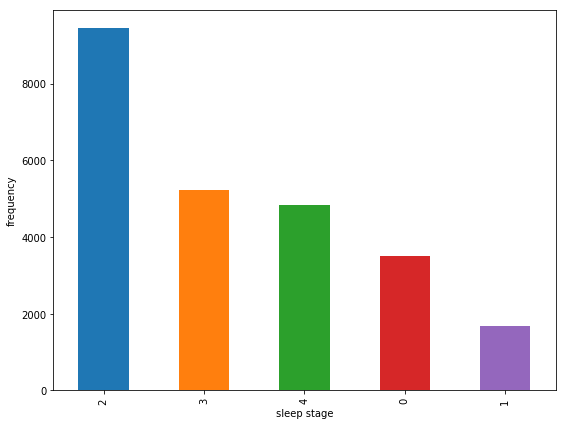

In [15]:
y["sleep_stage"].value_counts().plot.bar(figsize=(9,7))
plt.xlabel("sleep stage")
plt.ylabel("frequency")
plt.show()

In [16]:
data = xr.open_dataset("X_train.h5")

In [17]:
data = data.drop(["index","index_absolute","index_window"])

In [18]:
data.keys()

KeysView(<xarray.Dataset>
Dimensions:  (phony_dim_0: 24688, phony_dim_1: 1500, phony_dim_2: 300)
Dimensions without coordinates: phony_dim_0, phony_dim_1, phony_dim_2
Data variables:
    eeg_1    (phony_dim_0, phony_dim_1) float32 ...
    eeg_2    (phony_dim_0, phony_dim_1) float32 ...
    eeg_3    (phony_dim_0, phony_dim_1) float32 ...
    eeg_4    (phony_dim_0, phony_dim_1) float32 ...
    eeg_5    (phony_dim_0, phony_dim_1) float32 ...
    eeg_6    (phony_dim_0, phony_dim_1) float32 ...
    eeg_7    (phony_dim_0, phony_dim_1) float32 ...
    pulse    (phony_dim_0, phony_dim_2) float32 ...
    x        (phony_dim_0, phony_dim_2) float32 ...
    y        (phony_dim_0, phony_dim_2) float32 ...
    z        (phony_dim_0, phony_dim_2) float32 ...)

In [19]:
## build of a dictionary containing the dataframe of each variable
dict_df ={}
for var in list(data.data_vars):
    dict_df[var] = pd.DataFrame(data[var].values)

In [20]:
def plot_signals(start_idx,end_idx,variables=["eeg_1","pulse","x"]):
    n_vars = len(data.data_vars)
    fig,ax = plt.subplots(len(variables)+1,1,figsize=(20,16))
    for i,var in enumerate(variables) :
        start = start_idx * data[var].shape[1]
        end = end_idx * data[var].shape[1]
        array_var = data[var].values.reshape(1,-1)[0][start:end]
        ax[i].plot(array_var,color="blue",label=var)
        ax[i].legend()
    ax[len(variables)].plot(y.values.reshape(1,-1)[0][start_idx:end_idx],color="red",label="sleep_stage")
    ax[len(variables)].legend()

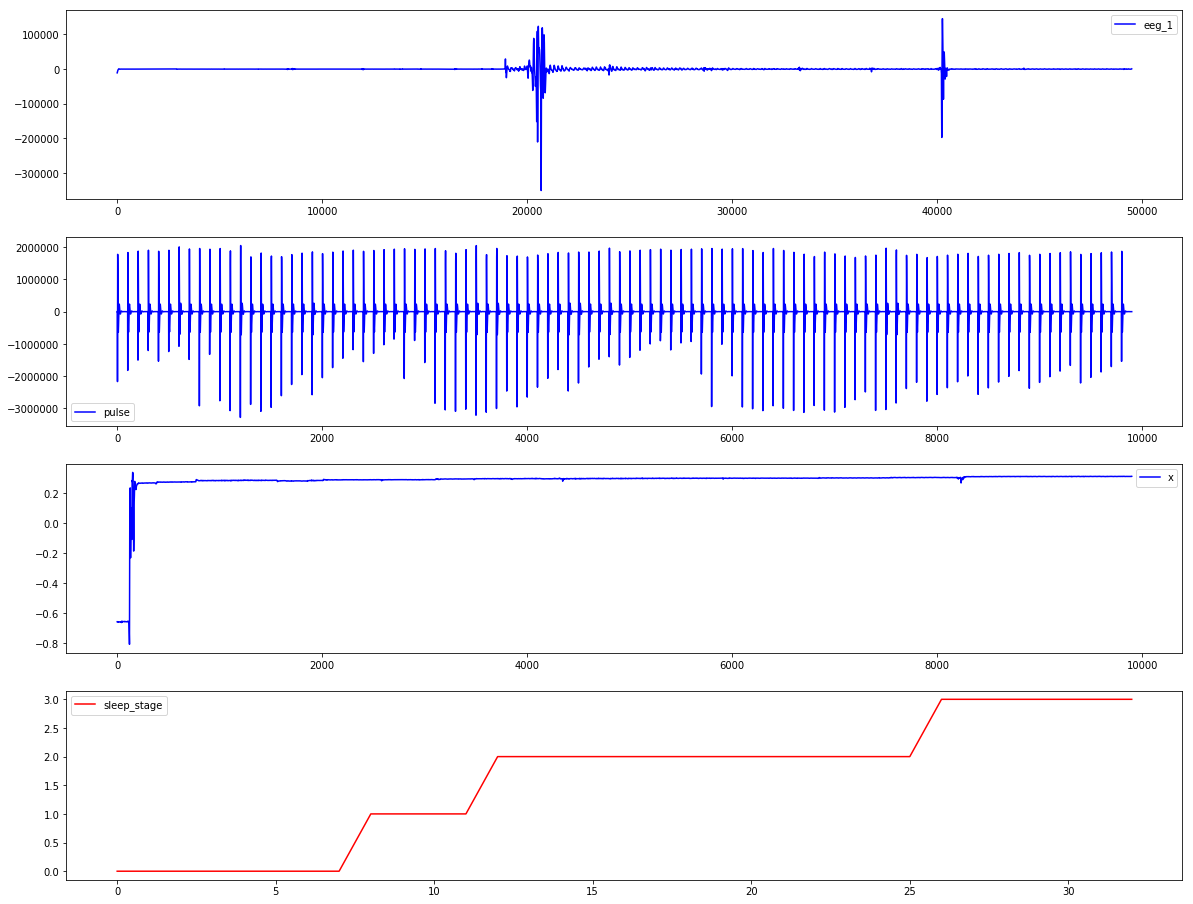

In [21]:
plot_signals(start_idx=137,end_idx=170)

# 2. Feature extraction :

In [41]:
from scipy import signal

In [42]:
import tsfresh.feature_extraction.feature_calculators as fc

## 2.1 statistical functions definition :

In [43]:
def abs_energy(x):
    return(fc.abs_energy(x))

In [44]:
def absolute_sum_of_changes(x):
    return(fc.absolute_sum_of_changes(x))

In [45]:
def agg_autocorrelation(x, param = [{"f_agg": "mean", "maxlag": 30}]):
    return(fc.agg_autocorrelation(x, param = param)[0][1])

In [46]:
#test ADF est un test statistique qui vise à savoir si une série temporelle est stationnaire
def augmented_dickey_fuller(x, param = [{"attr": "teststat"}]):
    return(fc.augmented_dickey_fuller(x, param = param)[0][1])

In [47]:
def binned_entropy(x, param = 30):
    return(fc.binned_entropy(x, max_bins = param))

In [48]:
# measure of non linearity in the time series
def c3(x, param = 30):
    return(fc.c3(x, lag = param))

In [49]:
def cid_ce(x, param = False):
    return(fc.cid_ce(x, normalize = param))

In [50]:
def count_above_mean(x):
    return(fc.count_above_mean(x))

In [51]:
def count_below_mean(x):
    return(fc.count_below_mean(x))

In [52]:
#the kurtosis of x (calculated with the adjusted Fisher-Pearson standardized moment coefficient G2).
def kurtosis(x):
    return(fc.kurtosis(x))

In [81]:
def number_crossing_m(x, param = 0):
    return(fc.number_crossing_m(x, m = param))

In [82]:
def linear_trend(x, param = [{"attr": "stderr"}]):
    return(fc.linear_trend(x, param = param)[0][1])

In [83]:
def mean(x):
    return(fc.mean(x))

In [84]:
def last_quantile(x):
    return(fc.quantile(x, 0.75))

In [85]:
def median(x):
    return(fc.median(x))


In [234]:
def max_min(x):
    return(np.max(x) - np.min(x))

In [90]:
def welch_power(x):
    fs = len(x)/30
    f, Pxx_den = signal.welch(x, fs)
    return(np.mean(Pxx_den))
    

In [235]:
def variance(x):
    return(fc.variance(x))

In [236]:
def first_quantile(x):
    return(fc.quantile(x, 0.25))

In [237]:
def skewness(x):
    return(fc.skewness(x))

In [238]:
# param ici c'est la frequence
def dsp(x):
    freq = int(len(x)/30)
    reel = np.real(np.fft.fft(x))
    imag = np.imag(np.fft.fft(x))
    return(np.sum(np.sqrt(np.add(reel **2 , imag **2))) * freq * 0.5)

In [239]:
def chunk(it, size):
    it     = iter(it)
    chunks = list(iter(lambda: tuple(islice(it, size)), ()))
    return([list(i) for i in chunks])

def MMD_distance(x):

    arg_min, minimum = np.argmin(x), np.min(x)
    arg_max, maximum = np.argmax(x), np.max(x)
    return(np.sqrt((arg_max - arg_min)**2 + (maximum - minimum)**2))

def MMD(x, param = None):
    distances = []
    n         = len(x)
    lambd     = 100
    for l in chunk(x, lambd):
        distances.append(MMD_distance(l))
    return(np.sum(np.abs(distances)))

In [240]:
def esis(x, param = {"lambda": 100, "f": 50}):
    return(np.sum(np.abs(np.fft.rfft(x)) * param["lambda"] * param["f"] ))

## 2.2 Immediate feature extraction :

In [53]:
def prepare_features(input_data, features =["abs_energy","number_crossing_m", "MMD", "first_quantile", 
                                            "variance", "skewness", "kurtosis", "linear_trend", "mean", 
                                            "last_quantile","esis", "welch_power", "max_min", "median"]):
    res = pd.DataFrame()
    for data_name in input_data.keys():
        for feature in features:
            print(data_name + ":" + feature)
            res[data_name+ "_" + feature] = input_data[data_name].apply(func = globals()[feature] ,axis = 1)
    return(res)

In [91]:
features = ["abs_energy","number_crossing_m", "MMD", "first_quantile", "variance", "skewness", 
            "kurtosis", "linear_trend", "mean", "last_quantile","esis", "welch_power", "max_min", "median"]

In [92]:
df_featured  = prepare_features(dict_df, features = features)

eeg_1:abs_energy
eeg_1:number_crossing_m
eeg_1:MMD
eeg_1:first_quantile
eeg_1:variance
eeg_1:skewness
eeg_1:kurtosis
eeg_1:linear_trend
eeg_1:mean
eeg_1:last_quantile
eeg_1:esis
eeg_1:welch_power
eeg_1:max_min
eeg_1:median
eeg_2:abs_energy
eeg_2:number_crossing_m
eeg_2:MMD
eeg_2:first_quantile
eeg_2:variance
eeg_2:skewness
eeg_2:kurtosis
eeg_2:linear_trend
eeg_2:mean
eeg_2:last_quantile
eeg_2:esis
eeg_2:welch_power
eeg_2:max_min
eeg_2:median
eeg_3:abs_energy
eeg_3:number_crossing_m
eeg_3:MMD
eeg_3:first_quantile
eeg_3:variance
eeg_3:skewness
eeg_3:kurtosis
eeg_3:linear_trend
eeg_3:mean
eeg_3:last_quantile
eeg_3:esis
eeg_3:welch_power
eeg_3:max_min
eeg_3:median
eeg_4:abs_energy
eeg_4:number_crossing_m
eeg_4:MMD
eeg_4:first_quantile
eeg_4:variance
eeg_4:skewness
eeg_4:kurtosis
eeg_4:linear_trend
eeg_4:mean
eeg_4:last_quantile
eeg_4:esis
eeg_4:welch_power
eeg_4:max_min
eeg_4:median
eeg_5:abs_energy
eeg_5:number_crossing_m
eeg_5:MMD
eeg_5:first_quantile
eeg_5:variance
eeg_5:skewness
eeg_5:

In [93]:
df_featured.head()

,eeg_1_abs_energy,eeg_1_number_crossing_m,eeg_1_MMD,eeg_1_first_quantile,eeg_1_variance,eeg_1_skewness,eeg_1_kurtosis,eeg_1_linear_trend,eeg_1_mean,eeg_1_last_quantile,...,z_variance,z_skewness,z_kurtosis,z_linear_trend,z_mean,z_last_quantile,z_esis,z_welch_power,z_max_min,z_median
0,4.299650e+13,284,2.966215e+06,-25.077618,2.866428e+10,-7.562576,89.693062,10.101794,1.433036,25.233244,...,0.000026,0.704648,3.929836,0.000003,0.934450,0.936514,1.434127e+06,0.000004,0.034359,0.935650
1,3.720482e+13,156,4.341572e+06,-66.371605,2.480321e+10,4.449780,40.995365,9.397177,58.033649,46.727496,...,0.002260,-1.585842,1.900744,0.000022,0.909571,0.938622,1.547324e+06,0.000082,0.213442,0.937507
2,7.405562e+08,189,2.319557e+04,-63.772789,4.901778e+05,-2.023675,21.011580,0.041376,-59.387016,45.126340,...,0.273178,-0.181109,-1.649390,0.000350,0.375378,0.889000,1.964026e+06,0.050183,1.546291,0.353569
3,1.040740e+13,127,1.842673e+06,-370.032135,6.938248e+09,1.197348,9.254307,4.970145,-2.420922,380.084824,...,0.000147,-3.668887,14.751987,0.000008,0.979638,0.983405,1.567457e+06,0.000002,0.107966,0.982871
4,7.079226e+08,145,3.015515e+04,-123.731129,4.719367e+05,2.425616,13.327626,0.040990,3.366298,91.557135,...,0.060163,-0.710009,-0.954534,0.000102,0.789568,0.987415,2.190816e+06,0.007408,0.849139,0.983055


In [94]:
df_featured.to_csv("df_featured.csv")

## 2.3 frequency band decomposition and corresponding feature extraction :

In [54]:
def filter_signal(x, Wn, fs = 50):

    Wn        = [Wn[0]/(0.5 * fs), Wn[1]/(0.5 * fs)]
    sos       = signal.butter(N = 5, Wn = Wn, analog=False, btype = 'band', output='sos')
    filtered  = signal.sosfilt(sos, x)
    return(pd.Series(filtered))

In [78]:
def prepare_eeg_bands_features(input_data, features =["max_min", "first_quantile", "variance",
                                                      "kurtosis", "skewness", "MMD","esis", "dsp"]):
    
    
    def get_band_stats(x, stats= features):
        
        eeg_bands = {'Delta': (0.001, 4),
                 'Theta': (4, 8),
                 'Alpha': (8, 12),
                 'Beta': (12, 22),
                 'Gamma': (22, 24.99)}
        
        res = []
        filtred   = pd.concat([filter_signal(x, Wn =eeg_bands["Delta"], fs = 50 ),
                               filter_signal(x, Wn =eeg_bands["Theta"], fs = 50 ),
                               filter_signal(x, Wn =eeg_bands["Alpha"], fs = 50 ),
                               filter_signal(x, Wn =eeg_bands["Beta"], fs = 50 ),
                               filter_signal(x, Wn =eeg_bands["Gamma"], fs = 50 )], axis = 1)

        for stat in stats:
            df_res = filtred.apply(func = globals()[stat], axis = 0)
            res.extend(df_res)
        return(res)
    
    
    res = pd.DataFrame()
    for data_name in input_data.keys():
        if "eeg" in data_name:
            df_band_features = pd.DataFrame(list(input_data[data_name].apply(get_band_stats, axis = 1)))
            df_band_features.columns = [data_name+"_" + a + "_" + b for a in features for \
                                     b in ["delta", "theta", "alpha", "beta", "gamma"]]
        res = pd.concat([res, df_band_features], axis = 1)
        print(res.head())
        print(res.shape)
    return(res)


In [79]:
df_bands_featured = prepare_eeg_bands_features(dict_df)

   eeg_1_max_min_delta  eeg_1_max_min_theta  eeg_1_max_min_alpha  \
0         2.535600e+06         1.023558e+06        674260.276425   
1         2.155856e+06         2.302109e+05         23209.684911   
2         7.432108e+03         3.355437e+03          2420.217439   
3         7.729231e+05         3.807778e+04          6512.385718   
4         6.501292e+03         1.365589e+03           911.238291   

   eeg_1_max_min_beta  eeg_1_max_min_gamma  eeg_1_first_quantile_delta  \
0       711161.974818        187800.941959                  -91.667007   
1         9587.888711           978.579229                  -58.250502   
2         2954.579517           970.034364                  -27.580786   
3         3066.114332           318.715040                 -368.238112   
4          620.836849            75.976200                 -111.424702   

   eeg_1_first_quantile_theta  eeg_1_first_quantile_alpha  \
0                   -8.303348                   -6.095788   
1                  -16.4

   eeg_4_max_min_delta  eeg_4_max_min_theta  eeg_4_max_min_alpha  \
0         1.790629e+06        721430.975842        475244.571618   
1         2.982042e+06        229443.698929         28767.775501   
2         8.799791e+05         61425.313205         13162.203613   
3         7.631823e+05         37151.310649          6454.685067   
4         1.852568e+06        111511.114630         63841.708837   

   eeg_4_max_min_beta  eeg_4_max_min_gamma  eeg_4_first_quantile_delta  \
0       501274.107786        132376.430262                 -115.971927   
1        11099.818117          1079.253874                -8509.789629   
2         7661.917340           349.268019                 -921.807885   
3         2964.347240           423.576804                 -724.122808   
4        87703.657297         29767.742612               -83051.581593   

   eeg_4_first_quantile_theta  eeg_4_first_quantile_alpha  \
0                  -14.902846                   -6.603585   
1                 -132.8

   eeg_7_max_min_delta  eeg_7_max_min_theta  eeg_7_max_min_alpha  \
0         2.509493e+06         1.013020e+06        667322.563640   
1         2.153362e+06         2.304071e+05         23241.387774   
2         9.020574e+03         3.499827e+03          2479.239294   
3         7.725300e+05         3.814663e+04          6534.693067   
4         9.100311e+03         3.372551e+03          1787.837955   

   eeg_7_max_min_beta  eeg_7_max_min_gamma  eeg_7_first_quantile_delta  \
0       703850.103092        185872.827134                   54.100678   
1         9653.213804           973.457148                  -29.143810   
2         2895.035146           929.799930                 -104.146173   
3         3121.643128           314.848979                 -243.884598   
4         2261.092880           398.465695                 -413.328830   

   eeg_7_first_quantile_theta  eeg_7_first_quantile_alpha  \
0                   -6.793483                   -5.549381   
1                  -16.8

In [80]:
df_bands_featured.to_csv("df_bands_featured.csv")

In [95]:
df_final_featured = pd.concat([df_featured, df_bands_featured], axis = 1)

# 3. Pre-processing post feature extraction :

In [22]:
df_final_featured = pd.read_csv("df_final_featured.csv",index_col=0)

In [23]:
df_final_featured.shape

(24688, 594)

## 3.1 Data scaling :

In [223]:
scaler = StandardScaler()
scaler.fit(df_final_featured)
def scale_data(df, scaler):
    df_scaled = pd.DataFrame(scaler.transform(df.values))
    df_scaled.columns = df.columns
    return(df_scaled)

In [224]:
df_final_scaled = scale_data(df_final_featured, scaler)

In [225]:
df_final_scaled.head()

,eeg_1_abs_energy,eeg_1_number_crossing_m,eeg_1_MMD,eeg_1_first_quantile,eeg_1_variance,eeg_1_skewness,eeg_1_kurtosis,eeg_1_linear_trend,eeg_1_mean,eeg_1_last_quantile,...,eeg_7_esis_delta.4,eeg_7_esis_theta.4,eeg_7_esis_alpha.4,eeg_7_esis_beta.4,eeg_7_esis_gamma.4,eeg_7_dsp_delta.4,eeg_7_dsp_theta.4,eeg_7_dsp_alpha.4,eeg_7_dsp_beta.4,eeg_7_dsp_gamma.4
0,4.528400,1.227721,4.960259,0.045826,4.529718,-4.876566,3.728964,9.680553,0.005033,-0.039659,...,13.573446,23.999110,33.239927,43.332843,50.800438,13.581840,23.999924,33.240386,43.333228,50.813792
1,3.911900,-0.397486,7.303690,0.036765,3.913048,2.760529,1.478418,8.998059,0.178892,-0.033241,...,11.209087,5.277062,1.208205,0.609579,0.260178,11.216273,5.277235,1.208223,0.609583,0.260250
2,-0.048319,0.021512,-0.054265,0.037335,-0.048317,-1.355099,0.554874,-0.063995,-0.181786,-0.033719,...,-0.071992,-0.009638,0.047941,0.093685,0.181665,-0.072087,-0.009637,0.047943,0.093686,0.181674
3,1.059426,-0.765697,3.045888,-0.029868,1.059747,0.692731,0.011516,4.710023,-0.006805,0.066301,...,4.491243,0.930559,0.303345,0.143277,0.037619,4.494483,0.930588,0.303350,0.143278,0.037353
4,-0.048323,-0.537152,-0.042407,0.024178,-0.048320,1.473626,0.199763,-0.064369,0.010972,-0.019855,...,-0.048175,0.047177,0.080526,0.078100,0.061225,-0.048158,0.047177,0.080528,0.078101,0.061185


## 3.2 Feature selection :

In [25]:
from feature_selector import FeatureSelector
# Features are in train and labels are in train_labels
train_labels = df_final_featured.columns
fs = FeatureSelector(data = df_final_featured, labels = y["sleep_stage"])

### 3.2.1 missing values :

In [26]:
fs.identify_missing(missing_threshold = 0.4)

0 features with greater than 0.40 missing values.



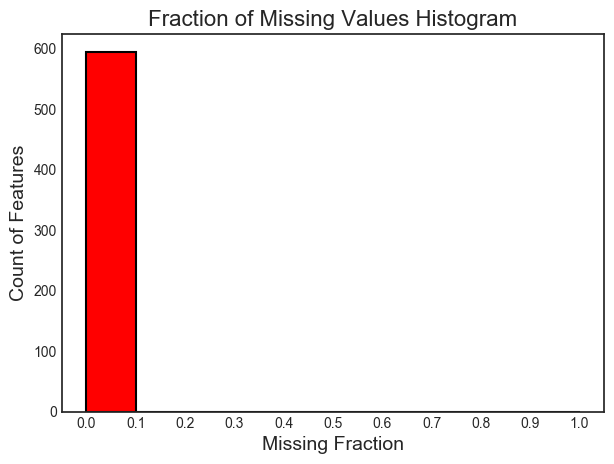

In [27]:
fs.plot_missing()

### 3.2.2 single unique values :

In [28]:
fs.identify_single_unique()

0 features with a single unique value.



### 3.2.3 Collinear (highly correlated) Features :

In [29]:
fs.identify_collinear(correlation_threshold = 0.99)

257 features with a correlation magnitude greater than 0.99.



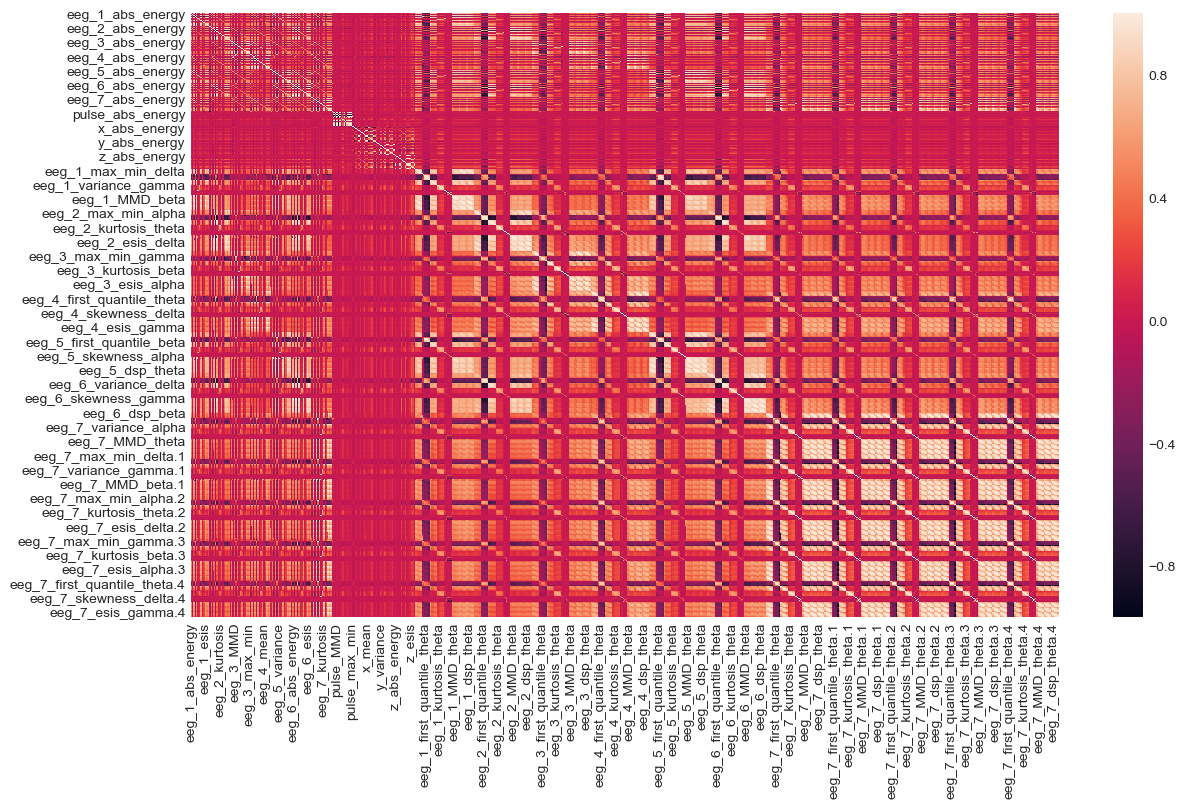

In [212]:
fig = plt.figure(figsize=(14,8))
sns.heatmap(df_final_scaled.corr())

In [30]:
# list of collinear features to remove
collinear_features = fs.ops['collinear']
# dataframe of collinear features
fs.record_collinear.head()

,drop_feature,corr_feature,corr_value
0,eeg_1_variance,eeg_1_abs_energy,1.0
1,eeg_2_variance,eeg_2_abs_energy,1.0
2,eeg_3_variance,eeg_3_abs_energy,1.0
3,eeg_4_variance,eeg_4_abs_energy,1.0
4,eeg_5_variance,eeg_5_abs_energy,1.0


### 3.2.4 Zero importance Features :

In [32]:
fs.identify_zero_importance(task = 'classification', eval_metric = 'auc', 
                            n_iterations = 10, early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid_0's auc: 0.0747536
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid_0's auc: 0.0761691
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid_0's auc: 0.0826585
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid_0's auc: 0.076252
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid_0's auc: 0.067372
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid_0's auc: 0.0649505
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid_0's auc: 0.0699921
Training until validation scores don't improve for 100 rounds.
Early stopping, 

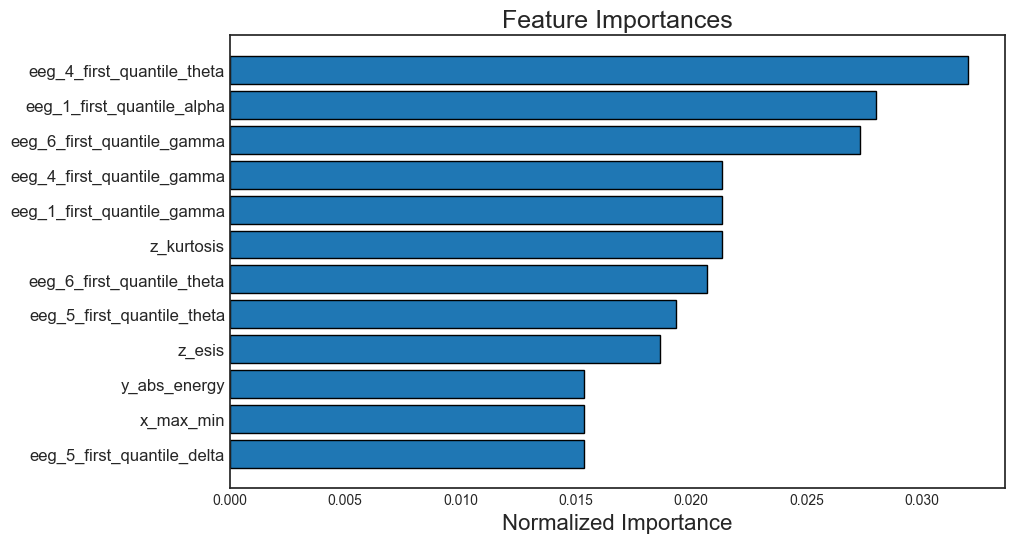

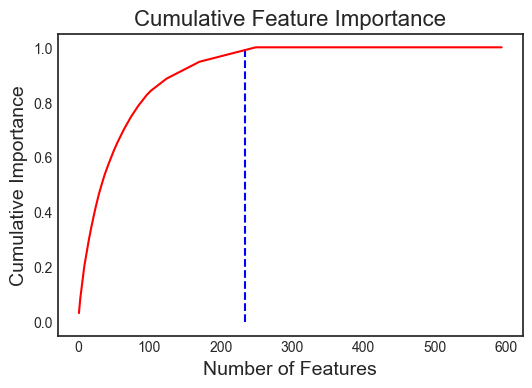

234 features required for 0.99 of cumulative importance


In [33]:
# plot the feature importances
fs.plot_feature_importances(threshold = 0.99, plot_n = 12)

In [34]:
features_to_remove = fs.check_removal()

Total of 395 features identified for removal


In [35]:
df_final_featured_sub = fs.remove(methods = ['missing', 'single_unique', 'collinear', 'zero_importance'])

Removed 395 features.


In [36]:
df_final_featured_sub.head()

,eeg_1_number_crossing_m,eeg_1_MMD,eeg_1_first_quantile,eeg_1_last_quantile,eeg_1_welch_power,eeg_1_median,eeg_2_abs_energy,eeg_2_number_crossing_m,eeg_2_first_quantile,eeg_2_mean,...,eeg_7_first_quantile_theta,eeg_7_first_quantile_alpha,eeg_7_first_quantile_beta,eeg_7_variance_alpha,eeg_7_variance_gamma,eeg_7_kurtosis_delta,eeg_7_kurtosis_gamma,eeg_7_skewness_delta,eeg_7_MMD_alpha,eeg_7_esis_alpha
0,284,2.966215e+06,-25.077618,25.233244,5.266010e+07,-2.341661,3.847213e+12,63,-148.984283,-4.143493,...,-6.793483,-5.549381,-5.537982,4.438133e+08,3.861727e+07,78.798775,152.380262,6.849425,668718.218245,1.413782e+12
1,156,4.341572e+06,-66.371605,46.727496,8.796627e+08,-11.648855,3.814513e+13,23,-10276.704346,42.036106,...,-16.860865,-9.210827,-7.968895,8.139059e+05,1.693667e+03,42.291932,65.066856,-4.445349,53420.884149,5.499621e+10
2,189,2.319557e+04,-63.772789,45.126340,5.654192e+03,-4.925843,9.991311e+12,50,-1462.289551,-26.924648,...,-16.507717,-11.522178,-7.999801,8.643248e+03,1.044840e+03,18.255306,131.005722,2.238627,5075.062425,5.777789e+09
3,127,1.842673e+06,-370.032135,380.084824,3.194594e+08,8.996914,1.826274e+12,50,-1047.249695,-5630.202637,...,-45.529115,-18.048607,-10.190810,7.325203e+04,2.154784e+02,9.398925,45.041652,-1.192407,15232.732299,1.661205e+10
4,145,3.015515e+04,-123.731129,91.557135,1.718518e+04,0.920760,8.717584e+13,29,-77662.611328,5629.494141,...,-69.221272,-28.828692,-16.221428,1.525370e+04,3.181472e+02,3.892622,50.927685,-0.236974,9350.994302,7.160072e+09


# 4. Fine tuning model hyper-parameters :

## 4.1 GRID SEARCH XGBOOST :

[ 100  300  500  700  900 1100 1300 1500]
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] n_estimators=100 ................................................
[CV] n_estimators=100 ................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

[CV] n_estimators=100 ................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] n_estimators=100 ................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................. n_estimators=100, total= 4.8min
[CV] n_estimators=100 ................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................. n_estimators=100, total= 4.8min
[CV] n_estimators=300 ................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................. n_estimators=100, total= 4.8min
[CV] n_estimators=300 ................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................. n_estimators=100, total= 4.8min
[CV] n_estimators=300 ................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................. n_estimators=100, total= 4.8min
[CV] n_estimators=300 ................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................. n_estimators=300, total=14.4min
[CV] n_estimators=300 ................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................. n_estimators=300, total=14.4min
[CV] n_estimators=500 ................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................. n_estimators=300, total=14.5min
[CV] n_estimators=500 ................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................. n_estimators=300, total=14.6min
[CV] n_estimators=500 ................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................. n_estimators=300, total=15.4min
[CV] n_estimators=500 ................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................. n_estimators=500, total=24.3min
[CV] n_estimators=500 ................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................. n_estimators=500, total=24.3min
[CV] n_estimators=700 ................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................. n_estimators=500, total=22.9min
[CV] n_estimators=700 ................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................. n_estimators=500, total=19.9min
[CV] n_estimators=700 ................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................. n_estimators=500, total=18.3min
[CV] n_estimators=700 ................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................. n_estimators=700, total=26.3min
[CV] n_estimators=700 ................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................. n_estimators=700, total=27.8min
[CV] n_estimators=900 ................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................. n_estimators=700, total=30.3min
[CV] n_estimators=900 ................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................. n_estimators=700, total=32.9min
[CV] n_estimators=900 ................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................. n_estimators=700, total=34.2min
[CV] n_estimators=900 ................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................. n_estimators=900, total=42.7min
[CV] n_estimators=900 ................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................. n_estimators=900, total=42.2min
[CV] n_estimators=1100 ...............................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................. n_estimators=900, total=41.3min
[CV] n_estimators=1100 ...............................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................. n_estimators=900, total=40.9min
[CV] n_estimators=1100 ...............................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................. n_estimators=900, total=41.4min
[CV] n_estimators=1100 ...............................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................ n_estimators=1100, total=50.3min
[CV] n_estimators=1100 ...............................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................ n_estimators=1100, total=50.0min
[CV] n_estimators=1300 ...............................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................ n_estimators=1100, total=52.1min
[CV] n_estimators=1300 ...............................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................ n_estimators=1100, total=53.2min
[CV] n_estimators=1300 ...............................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................ n_estimators=1100, total=55.1min
[CV] n_estimators=1300 ...............................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................ n_estimators=1300, total=67.0min
[CV] n_estimators=1300 ...............................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................ n_estimators=1300, total=66.5min
[CV] n_estimators=1500 ...............................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................ n_estimators=1300, total=66.6min
[CV] n_estimators=1500 ...............................................


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 279.7min
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................ n_estimators=1300, total=66.3min
[CV] n_estimators=1500 ...............................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................ n_estimators=1300, total=64.9min
[CV] n_estimators=1500 ...............................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................ n_estimators=1500, total=71.1min
[CV] n_estimators=1500 ...............................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................ n_estimators=1500, total=67.8min
[CV] ................................ n_estimators=1500, total=60.8min
[CV] ................................ n_estimators=1500, total=49.9min
[CV] ................................ n_estimators=1500, total=41.0min


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 377.0min finished
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best: -0.414097 using {'n_estimators': 1300}
-0.605331 (0.008516) with: {'n_estimators': 100}
-0.484604 (0.010571) with: {'n_estimators': 300}
-0.448998 (0.009866) with: {'n_estimators': 500}
-0.431846 (0.010415) with: {'n_estimators': 700}
-0.422232 (0.011217) with: {'n_estimators': 900}
-0.416290 (0.012079) with: {'n_estimators': 1100}
-0.414097 (0.012872) with: {'n_estimators': 1300}
-0.414520 (0.013777) with: {'n_estimators': 1500}


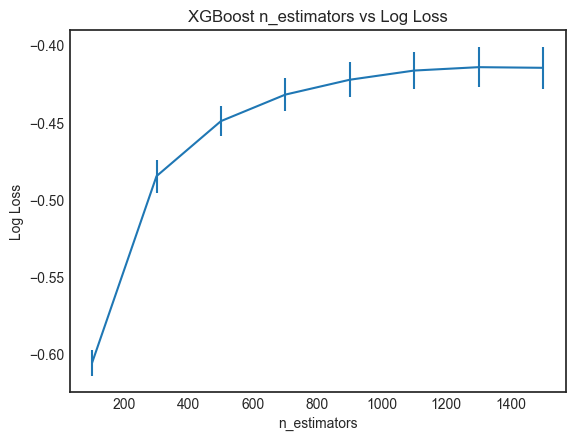

In [89]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

model = XGBClassifier()
n_estimators = np.arange(100, 1600, 200)
print(n_estimators)

param_grid = dict(n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=2)
grid_result = grid_search.fit(df_final_featured_sub, y)


Best: -0.414097 using {'n_estimators': 1300}
-0.605331 (0.008516) with: {'n_estimators': 100}
-0.484604 (0.010571) with: {'n_estimators': 300}
-0.448998 (0.009866) with: {'n_estimators': 500}
-0.431846 (0.010415) with: {'n_estimators': 700}
-0.422232 (0.011217) with: {'n_estimators': 900}
-0.416290 (0.012079) with: {'n_estimators': 1100}
-0.414097 (0.012872) with: {'n_estimators': 1300}
-0.414520 (0.013777) with: {'n_estimators': 1500}


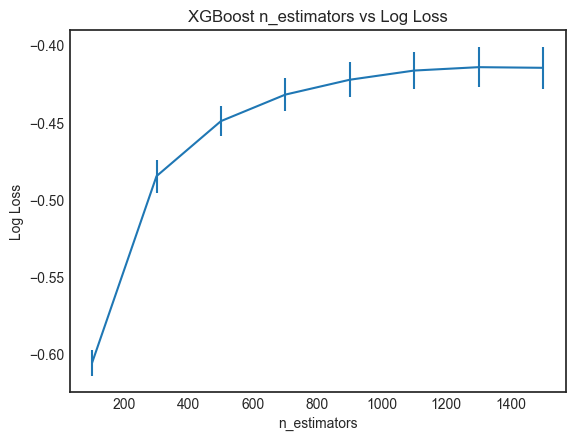

In [94]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# plot
plt.errorbar(n_estimators, means, yerr=stds)
plt.title("XGBoost n_estimators vs Log Loss")
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.savefig('n_estimators.png')

In [92]:
best_n_estimator = grid_result.best_params_["n_estimators"]

In [93]:
best_n_estimator

1300

In [97]:
model = XGBClassifier(n_estimators = best_n_estimator)
max_depth = np.arange(5, 100, 15)
print(max_depth)
param_grid = dict(max_depth=max_depth)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=2)
grid_result = grid_search.fit(df_final_featured_sub, y)

[ 5 20 35 50 65 80 95]
Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] max_depth=5 .....................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] max_depth=5 .....................................................
[CV] max_depth=5 .....................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] max_depth=5 .....................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

[CV] ...................................... max_depth=5, total=66.4min
[CV] max_depth=5 .....................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...................................... max_depth=5, total=66.5min
[CV] max_depth=20 ....................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...................................... max_depth=5, total=66.6min
[CV] max_depth=20 ....................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...................................... max_depth=5, total=66.7min
[CV] max_depth=20 ....................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...................................... max_depth=5, total=54.6min
[CV] max_depth=20 ....................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................................... max_depth=20, total=70.3min
[CV] max_depth=20 ....................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................................... max_depth=20, total=70.7min
[CV] max_depth=35 ....................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................................... max_depth=20, total=70.9min
[CV] max_depth=35 ....................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................................... max_depth=20, total=70.5min
[CV] max_depth=35 ....................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................................... max_depth=20, total=70.3min
[CV] max_depth=35 ....................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................................... max_depth=35, total=71.1min
[CV] max_depth=35 ....................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................................... max_depth=35, total=71.5min
[CV] max_depth=50 ....................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................................... max_depth=35, total=71.2min
[CV] max_depth=50 ....................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................................... max_depth=35, total=71.3min
[CV] max_depth=50 ....................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................................... max_depth=35, total=71.1min
[CV] max_depth=50 ....................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................................... max_depth=50, total=70.9min
[CV] max_depth=50 ....................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................................... max_depth=50, total=71.4min
[CV] max_depth=65 ....................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................................... max_depth=50, total=71.5min
[CV] max_depth=65 ....................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................................... max_depth=50, total=70.8min
[CV] max_depth=65 ....................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................................... max_depth=50, total=71.4min
[CV] max_depth=65 ....................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................................... max_depth=65, total=71.3min
[CV] max_depth=65 ....................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................................... max_depth=65, total=71.5min
[CV] max_depth=80 ....................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................................... max_depth=65, total=71.1min
[CV] max_depth=80 ....................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................................... max_depth=65, total=71.6min
[CV] max_depth=80 ....................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................................... max_depth=65, total=70.9min
[CV] max_depth=80 ....................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................................... max_depth=80, total=71.4min
[CV] max_depth=80 ....................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................................... max_depth=80, total=71.1min
[CV] max_depth=95 ....................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................................... max_depth=80, total=71.9min
[CV] max_depth=95 ....................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................................... max_depth=80, total=71.4min
[CV] max_depth=95 ....................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................................... max_depth=80, total=71.0min
[CV] max_depth=95 ....................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................................... max_depth=95, total=71.1min
[CV] max_depth=95 ....................................................


/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................................... max_depth=95, total=72.0min
[CV] ..................................... max_depth=95, total=60.6min
[CV] ..................................... max_depth=95, total=53.6min
[CV] ..................................... max_depth=95, total=53.0min


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed: 620.1min finished
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best: -0.431967 using {'max_depth': 5}
-0.431967 (0.014712) with: {'max_depth': 5}
-0.496759 (0.014545) with: {'max_depth': 20}
-0.497434 (0.015682) with: {'max_depth': 35}
-0.496132 (0.015525) with: {'max_depth': 50}
-0.496132 (0.015525) with: {'max_depth': 65}
-0.496132 (0.015525) with: {'max_depth': 80}
-0.496132 (0.015525) with: {'max_depth': 95}


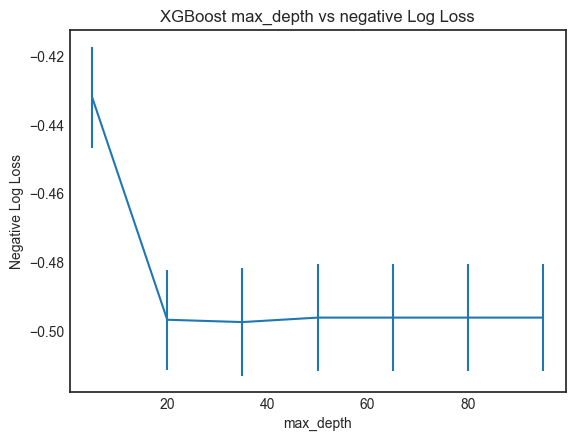

In [101]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# plot
plt.errorbar(max_depth, means, yerr=stds)
plt.title("XGBoost max_depth vs negative Log Loss")
plt.xlabel('max_depth')
plt.ylabel('Negative Log Loss')
plt.savefig('max_depth.png')


## 4.2 GRID SEARCH RANDOMFOREST :

In [72]:
from sklearn.model_selection import RandomizedSearchCV

In [81]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1500, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 6)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf=RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, 
                               verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(train_removed,y)



Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=450, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=False 
[CV] n_estimators=450, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=False 
[CV] n_estimators=450, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=False 


/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=False 


/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=False, total=  55.4s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=False 


/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=False, total=  56.0s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=False 


/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=False, total=  53.4s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=False 


/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=False, total=  54.4s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=False 


/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=450, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=False, total= 4.0min
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=False 


/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=450, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=False, total= 4.1min
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=False 


/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=450, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=False, total= 4.2min
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=False 


/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=False, total=  50.6s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=False 


/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=False, total=  47.6s
[CV] n_estimators=1500, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False 


/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=False, total=  46.3s
[CV] n_estimators=1500, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False 


/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=False, total=  47.7s
[CV] n_estimators=1500, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False 


/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=False, total=  45.9s
[CV] n_estimators=450, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=True 


/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=450, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=True, total= 2.0min
[CV] n_estimators=450, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=True 


/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=450, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=True, total= 2.1min
[CV] n_estimators=450, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=True 


/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=450, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=True, total= 2.0min
[CV] n_estimators=450, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=True 


/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=450, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=True, total= 2.2min
[CV] n_estimators=450, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=True 


/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=450, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=True, total= 2.3min
[CV] n_estimators=450, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=True 


/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=1500, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False, total=12.3min
[CV] n_estimators=1150, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False 


/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=1500, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False, total=12.1min
[CV] n_estimators=1150, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False 


/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=1500, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False, total=12.7min
[CV] n_estimators=1150, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False 


/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=450, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=True, total= 2.1min
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=70, bootstrap=True 


/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=70, bootstrap=True, total=  28.5s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=70, bootstrap=True 


/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=70, bootstrap=True, total=  29.8s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=70, bootstrap=True 


/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=70, bootstrap=True, total=  29.0s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True 


/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True, total= 2.6min
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True 


/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True, total= 2.7min
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True 


/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=1150, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False, total= 9.0min
[CV]  n_estimators=1150, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False, total= 8.9min
[CV]  n_estimators=1150, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False, total= 9.2min
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True, total= 2.2min


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 27.3min finished
/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [100, 450, 800, 1150, 1500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 30, 50, 70, 90, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [82]:
rf_random.best_params_

{'n_estimators': 1150,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

# 5. Final model results

In [123]:
X_train, X_test, y_train, y_test = train_test_split(df_final_featured_sub, y, stratify=y, test_size=0.3) # 70% training and 30% test

In [124]:
#Create an xgboost Classifier
xgb_clf = xgb.XGBClassifier(n_estimators=1300,max_depth=5, n_jobs = -1)
#Train the model using the training sets 
xgb_clf.fit(X_train,y_train)

/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1300,
       n_jobs=-1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [132]:
#Create a RF Classifier
rf_clf = RandomForestClassifier(n_estimators= 1150, min_samples_split= 5,
 min_samples_leaf= 2, max_features  = 'sqrt', max_depth = None, bootstrap = False, n_jobs = -1)
#Train the model using the training sets 
rf_clf.fit(X_train,y_train)

/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=1150, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [125]:
y_pred_xgb = xgb_clf.predict(X_test)

/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [133]:
y_pred_rf = rf_clf.predict(X_test)

In [135]:
print("XGB accuracy on test :",accuracy_score(y_test, y_pred_xgb))
print("RF accuracy on test :",accuracy_score(y_test, y_pred_rf))

XGB accuracy on test : 0.8597272850006751
RF accuracy on test : 0.8288105845821521


In [136]:
print("XGB f1_score on test :",f1_score(y_test, y_pred_xgb, average="weighted"))
print("RF f1_score on test :",f1_score(y_test, y_pred_rf, average="weighted"))

XGB f1_score on test : 0.8524164829592537
RF f1_score on test : 0.8151840750477131


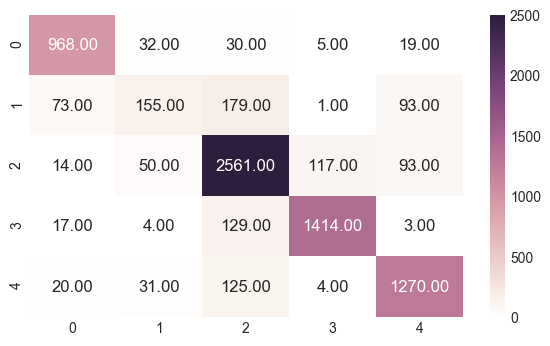

In [137]:
# Compute confusion matrix for XGBoost
cnf_matrix = confusion_matrix(y_test, y_pred_xgb)
df_cm = pd.DataFrame(cnf_matrix, index = xgb_clf.classes_,
                  columns = xgb_clf.classes_)
fig = plt.figure(figsize=(7,4))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
res = sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}, vmin=0.0, vmax=2500, fmt='.2f', cmap=cmap)


In [131]:
print("Classification Report")
print(classification_report(y_test, y_pred_xgb))

Classification Report
             precision    recall  f1-score   support

          0       0.89      0.92      0.90      1054
          1       0.57      0.31      0.40       501
          2       0.85      0.90      0.87      2835
          3       0.92      0.90      0.91      1567
          4       0.86      0.88      0.87      1450

avg / total       0.85      0.86      0.85      7407



# 6. Submission : 

In [38]:
features_to_keep = [col for col in df_final_featured.columns if col not in features_to_remove]

In [105]:
features_to_keep

['eeg_1_number_crossing_m',
 'eeg_1_MMD',
 'eeg_1_first_quantile',
 'eeg_1_last_quantile',
 'eeg_1_welch_power',
 'eeg_1_median',
 'eeg_2_abs_energy',
 'eeg_2_number_crossing_m',
 'eeg_2_first_quantile',
 'eeg_2_mean',
 'eeg_2_last_quantile',
 'eeg_2_esis',
 'eeg_2_welch_power',
 'eeg_2_median',
 'eeg_3_number_crossing_m',
 'eeg_3_first_quantile',
 'eeg_3_skewness',
 'eeg_3_mean',
 'eeg_3_max_min',
 'eeg_3_median',
 'eeg_4_number_crossing_m',
 'eeg_4_first_quantile',
 'eeg_4_kurtosis',
 'eeg_4_linear_trend',
 'eeg_4_last_quantile',
 'eeg_4_esis',
 'eeg_4_max_min',
 'eeg_4_median',
 'eeg_5_number_crossing_m',
 'eeg_5_first_quantile',
 'eeg_5_skewness',
 'eeg_5_kurtosis',
 'eeg_5_last_quantile',
 'eeg_5_esis',
 'eeg_5_welch_power',
 'eeg_5_max_min',
 'eeg_5_median',
 'eeg_6_abs_energy',
 'eeg_6_number_crossing_m',
 'eeg_6_first_quantile',
 'eeg_6_kurtosis',
 'eeg_6_mean',
 'eeg_6_last_quantile',
 'eeg_6_welch_power',
 'eeg_6_max_min',
 'eeg_7_number_crossing_m',
 'eeg_7_kurtosis',
 'eeg_

In [58]:
df_final_featured_sub = df_final_featured[features_to_keep]

In [118]:
#Create a random forest Classifier
rf_train_all = RandomForestClassifier(n_estimators= 1150, min_samples_split= 5,
 min_samples_leaf= 2, max_features  = 'sqrt', max_depth = None, bootstrap = False, n_jobs = -1)
xgb_train_all = xgb.XGBClassifier(n_estimators=1300,max_depth=5, n_jobs = -1)

#Train the model using the training sets y_pred=clf.predict(X_test)
#rf_train_all.fit(df_final_featured_sub,y)
xgb_train_all.fit(df_final_featured_sub,y)

/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1300,
       n_jobs=-1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [62]:
df_final_test_featured = pd.read_csv("df_final_test_featured.csv",index_col=0)

In [109]:
df_final_test_featured.shape

(24980, 594)

In [110]:
#df_final_test_scaled = scale_data(df_final_test_featured, scaler)

In [111]:
df_final_test = df_final_test_featured[features_to_keep]

In [112]:
df_final_test.shape

(24980, 199)

In [119]:
y_pred_test = xgb_train_all.predict(df_final_test)

/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [120]:
sample = pd.read_csv("sample_submission.csv", sep = ",")
sample["sleep_stage"] = y_pred_test

In [121]:
sample.head()

,index,sleep_stage
0,24688,0
1,24689,0
2,24690,0
3,24691,0
4,24692,0


In [122]:
sample.to_csv("result10.csv", index = False)

In [117]:
sample["sleep_stage"].value_counts()

2    11458
4     4949
3     4311
0     3842
1      420
Name: sleep_stage, dtype: int64